# Prova final da disciplina Análise Estatística de Dados e Informações - PPCA

Prof. João Gabriel de Moraes Souza

Aluno: Demétrius de Almeida Jubé

# Análise financeira do portifólio de varejistas da área de vestuário do Brasil

Para a nossa análise, serão consideradas as ações de quatro empresas de vestuário que atuam na B3:

| Empresa | Código | Destaque ou perfil corporativo |
|:---|:---:|---|
| Marisa | AMAR3.SA | A maior rede de moda feminina e lingerie do Brasil. É Prêmio Top of Mind na categoria e possui lojas físicas e online. |
| Guararapes | GUAR3.SA | Dona das marcas Riachuelo, Carter's e Midway Financeira. Toda  a confecção da Guararapes abastece as mais de 300 lojas da Riachuelo. |
| Arezzo | ARZZ3.SA | Dona das marcas Arezzo, Schutz e AnaCapri. Também vende produtos da marca Vans. É líder no setor de calçados, bolsas e acessórios femininos. Possui e-commerce e lojas físicas. |
| Lojas Renner | LREN3.SA | Dona das Lojas Renner, Camicado, Realize e Youcom. Possui mais de 600 lojas físicas no Brasil, Uruguai e Argentina, além de e-commerce. |

O índice que será utilizado para comparação será o IBOVESPA (^BVSP), e os objetivos da análise são os seguintes:

* Fazer a análise descritiva dos dados das ações
* Encontrar o portfólio que tenha o melhor Índice de Sharpe, juntamente com a Fronteira Eficiente
* Realizar ANOVA e Testes de Hipóteses
* Executar uma Regressão Linear e encontrar a relação de uma ação específica com o IBOVESPA
* Utilizar um modelo de previsão de Machine Learning para alguma ação

## Análise da performance da carteira

Para realização dos objetivos, vamos montar o ambiente e recuperar os dados que serão analisados:

### Setup do ambiente

Aqui, recuperaremos as bibliotecas que serão utilizadas para carregar e analisar os dados:

In [180]:
import pandas as pd
from pandas_datareader import data
import numpy as np
import math
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio
import seaborn as sns
from scipy import stats
from scipy import optimize

pio.renderers.default = 'notebook_connected'

### Construindo a base de dados com as ações selecionadas

Faremos uma lista das ações que queremos verificar na carteira e buscaremos as informações no Yahoo Finance, utilizando a biblioteca do Panda Datareader para isso.

In [181]:
portfolio = ['AMAR3.SA', 'GUAR3.SA', 'ARZZ3.SA', 'LREN3.SA']
indice = '^BVSP'
acoes = portfolio.copy()
acoes.append(indice)
print('Ações que serão pesquisadas:')
acoes

Ações que serão pesquisadas:


['AMAR3.SA', 'GUAR3.SA', 'ARZZ3.SA', 'LREN3.SA', '^BVSP']

In [182]:
acoes_df = pd.DataFrame()
for acao in acoes:
    acoes_df[acao] = data.DataReader(acao,
                                     data_source='yahoo', start='2015-01-01')['Close']

O resultado da pesquisa pode ser verificado abaixo:

In [183]:
acoes_df

,AMAR3.SA,GUAR3.SA,ARZZ3.SA,LREN3.SA,^BVSP
Date,,,,,
2015-01-02,13.190909,10.23000,25.850000,12.446208,48512.000000
2015-01-05,13.090909,9.90625,25.040001,12.100207,47517.000000
2015-01-06,12.281818,9.87375,24.549999,12.239591,48001.000000
2015-01-07,12.509090,10.05500,24.799999,12.447848,49463.000000
2015-01-08,12.372727,9.90750,24.680000,12.462606,49943.000000
...,...,...,...,...,...
2022-09-08,2.430000,10.35000,92.250000,26.020000,109916.000000
2022-09-09,2.560000,10.58000,93.150002,26.850000,112300.000000
2022-09-12,2.680000,10.71000,94.690002,27.410000,113407.000000


Por conta da cisão do Pão de Açucar e do Assaí em março de 2021, os dados recuperados estão vindo a partir dessa data.

Será necessário incluir um índice independente na lista, pois a pesquisa coloca como chave de cada registro a data. É possível fazer isso utilizando a função `reset_index` do `DataFrame`. Ao utilizarmos o argumento `inplace=True`, nós garantimos que não há nenhuma perda de dados.

In [184]:
acoes_df.reset_index(inplace=True)
acoes_df

,Date,AMAR3.SA,GUAR3.SA,ARZZ3.SA,LREN3.SA,^BVSP
0,2015-01-02,13.190909,10.23000,25.850000,12.446208,48512.000000
1,2015-01-05,13.090909,9.90625,25.040001,12.100207,47517.000000
2,2015-01-06,12.281818,9.87375,24.549999,12.239591,48001.000000
3,2015-01-07,12.509090,10.05500,24.799999,12.447848,49463.000000
4,2015-01-08,12.372727,9.90750,24.680000,12.462606,49943.000000
...,...,...,...,...,...,...
1910,2022-09-08,2.430000,10.35000,92.250000,26.020000,109916.000000
1911,2022-09-09,2.560000,10.58000,93.150002,26.850000,112300.000000
1912,2022-09-12,2.680000,10.71000,94.690002,27.410000,113407.000000
1913,2022-09-13,2.640000,10.00000,94.000000,27.219999,110794.000000


### Visualização dos Dados

A Biblioteca Ploty, do Python, nos permite visualizar, de forma gráfica, os dados que recuperamos. Vamos ver o histórico de preços das ações no decorrer do tempo:

In [185]:
figuraHistorico = px.line(title = 'Histórico do preço das ações')
for i in acoes_df.columns[1:]:
  figuraHistorico.add_scatter(x = acoes_df["Date"] ,y = acoes_df[i], name = i)
figuraHistorico.show()

É possível observar no gráfico o impacto da pandemia de Covid 19 nos papeis. Do portfólio, apenas a Arezzo teve um resultado superior ao da série histórica até aquele momento.

## Taxa de Retorno de Ações

Um dos indicadores que vamos analisar é a taxa de retorno das ações da carteira. Ela basicamente se define como a razão entre o valor atual e o valor anterior. Com os dados que temos, podemos acompanhar a evolução da taxa de retorno comparando o valor de fechamento de um dia com o valor do fechamento do dia anterior. Como há um intervalo de tempo entre esses dois pontos, essa diferença é abrupta, e é possível suavizá-la com o uso do `log`.

A expressão da Valor Esperado da taxa de retorno pode ser descrita assim:

$$ \mathbb{E} [ R_i] = log \left( \frac{P_t}{P_{t-1}} \right) $$

Como temos os dados variando no tempo, é possível fazer esse cálculo para cada registro. Felizmente não será necessário fazer a iteração manual dos dados, pois a  biblioteca `NumPy` tem, através da função `log`, a capacidade de fazer a operação utilizando dois `DataFrame`s, utilizando como argumento os de mesmo índice.

Já temos o `DataFrame` com os dados originais, e só nos falta montar outro com os dados do dia anterior, com o mesmo índice dos dados originais, para poder fazer o cálculo. O artifício que vamos usar para isso é a função `shift` do `DataFrame`. Essa função adiciona uma quantidade de registros no topo do `DataFrame`. Aplicando isso no nosso conjunto de dados, conseguiremos uma cópia dos dados do dia anterior, alinhados com o índice dos nossos dados originais.

O primeiro passo é copiar o `DataFrame` das ações:

In [186]:
dataset = acoes_df.copy()
dataset

,Date,AMAR3.SA,GUAR3.SA,ARZZ3.SA,LREN3.SA,^BVSP
0,2015-01-02,13.190909,10.23000,25.850000,12.446208,48512.000000
1,2015-01-05,13.090909,9.90625,25.040001,12.100207,47517.000000
2,2015-01-06,12.281818,9.87375,24.549999,12.239591,48001.000000
3,2015-01-07,12.509090,10.05500,24.799999,12.447848,49463.000000
4,2015-01-08,12.372727,9.90750,24.680000,12.462606,49943.000000
...,...,...,...,...,...,...
1910,2022-09-08,2.430000,10.35000,92.250000,26.020000,109916.000000
1911,2022-09-09,2.560000,10.58000,93.150002,26.850000,112300.000000
1912,2022-09-12,2.680000,10.71000,94.690002,27.410000,113407.000000
1913,2022-09-13,2.640000,10.00000,94.000000,27.219999,110794.000000


Com a cópia, vamos retirar a coluna `Date`, pois ela não será usada no cálculo: 

In [187]:
dataset.drop(labels = ['Date'], axis=1, inplace=True)
dataset

,AMAR3.SA,GUAR3.SA,ARZZ3.SA,LREN3.SA,^BVSP
0,13.190909,10.23000,25.850000,12.446208,48512.000000
1,13.090909,9.90625,25.040001,12.100207,47517.000000
2,12.281818,9.87375,24.549999,12.239591,48001.000000
3,12.509090,10.05500,24.799999,12.447848,49463.000000
4,12.372727,9.90750,24.680000,12.462606,49943.000000
...,...,...,...,...,...
1910,2.430000,10.35000,92.250000,26.020000,109916.000000
1911,2.560000,10.58000,93.150002,26.850000,112300.000000
1912,2.680000,10.71000,94.690002,27.410000,113407.000000
1913,2.640000,10.00000,94.000000,27.219999,110794.000000


Realizamos o `shift` para verificar o funcionamento e constatar que a primeira linha foi deslocada:

In [188]:
dataset.shift(1)

,AMAR3.SA,GUAR3.SA,ARZZ3.SA,LREN3.SA,^BVSP
0,NaN,NaN,NaN,NaN,NaN
1,13.190909,10.23000,25.850000,12.446208,48512.0
2,13.090909,9.90625,25.040001,12.100207,47517.0
3,12.281818,9.87375,24.549999,12.239591,48001.0
4,12.509090,10.05500,24.799999,12.447848,49463.0
...,...,...,...,...,...
1910,2.360000,10.10000,91.660004,26.030001,109764.0
1911,2.430000,10.35000,92.250000,26.020000,109916.0
1912,2.560000,10.58000,93.150002,26.850000,112300.0
1913,2.680000,10.71000,94.690002,27.410000,113407.0


O resultado das taxas de retorno pode ser visto abaixo:

In [189]:
taxas_retorno = np.log(dataset / dataset.shift(1))
taxas_retorno.fillna(0, inplace=True)
taxas_retorno

,AMAR3.SA,GUAR3.SA,ARZZ3.SA,LREN3.SA,^BVSP
0,0.000000,0.000000,0.000000,0.000000,0.000000
1,-0.007610,-0.032159,-0.031836,-0.028193,-0.020724
2,-0.063798,-0.003286,-0.019763,0.011453,0.010134
3,0.018336,0.018190,0.010132,0.016872,0.030003
4,-0.010961,-0.014778,-0.004850,0.001185,0.009657
...,...,...,...,...,...
1910,0.029230,0.024451,0.006416,-0.000384,0.001384
1911,0.052116,0.021979,0.009709,0.031400,0.021457
1912,0.045810,0.012212,0.016397,0.020642,0.009809
1913,-0.015038,-0.068593,-0.007314,-0.006956,-0.023310


A função `describe` do `DataFrame` pode nos proporcionar várias informações estatísticas importantes sobre as taxas de retorno:

In [190]:
taxas_retorno.describe()

,AMAR3.SA,GUAR3.SA,ARZZ3.SA,LREN3.SA,^BVSP
count,1915.000000,1915.000000,1915.000000,1915.000000,1915.000000
mean,-0.000848,-0.000012,0.000677,0.000408,0.000399
std,0.038603,0.030042,0.025123,0.024704,0.016274
min,-0.405465,-0.321605,-0.182322,-0.237244,-0.159930
25%,-0.021129,-0.015115,-0.012899,-0.012622,-0.007789
50%,-0.001483,0.000000,0.000000,0.000000,0.000559
75%,0.018263,0.014477,0.013967,0.013589,0.009225
max,0.287061,0.175832,0.153745,0.139762,0.130223


Agora podemos reconstruir os dados de retorno das ações, incluindo a data de cada registro, permitindo a visualização do comportamento do retorno ao longo do tempo. Para isso, podemos selecionar a coluna de data do `DataFrame` original e juntá-lo com a matriz das taxas de retorno. 

In [191]:
dataset_date = acoes_df.copy()
date = dataset_date.filter(["Date"]) 
date

,Date
0,2015-01-02
1,2015-01-05
2,2015-01-06
3,2015-01-07
4,2015-01-08
...,...
1910,2022-09-08
1911,2022-09-09
1912,2022-09-12
1913,2022-09-13


In [192]:
taxas_retorno_date = pd.concat([date, taxas_retorno], axis=1)
taxas_retorno_date

,Date,AMAR3.SA,GUAR3.SA,ARZZ3.SA,LREN3.SA,^BVSP
0,2015-01-02,0.000000,0.000000,0.000000,0.000000,0.000000
1,2015-01-05,-0.007610,-0.032159,-0.031836,-0.028193,-0.020724
2,2015-01-06,-0.063798,-0.003286,-0.019763,0.011453,0.010134
3,2015-01-07,0.018336,0.018190,0.010132,0.016872,0.030003
4,2015-01-08,-0.010961,-0.014778,-0.004850,0.001185,0.009657
...,...,...,...,...,...,...
1910,2022-09-08,0.029230,0.024451,0.006416,-0.000384,0.001384
1911,2022-09-09,0.052116,0.021979,0.009709,0.031400,0.021457
1912,2022-09-12,0.045810,0.012212,0.016397,0.020642,0.009809
1913,2022-09-13,-0.015038,-0.068593,-0.007314,-0.006956,-0.023310


E com isso, plotar um gráfico desse histórico:

In [193]:
figuraHistoricoRetorno = px.line(title = 'Histórico de retorno das ações')
for i in taxas_retorno_date.columns[1:]:
  figuraHistoricoRetorno.add_scatter(x = taxas_retorno_date["Date"] ,y = taxas_retorno_date[i], name = i)
figuraHistoricoRetorno.show()

### Covariância das taxas de retorno

O `DataFrame` nos permite verificar um dados interessante também: a *covariância* entre duas ações. No mercado financeiro, esse dado pode ser usado para avaliar como o  comportamento do preço de um ativo influencia no aumento ou diminuição de outro. No nosso caso, temos ao resultado abaixo: 

In [194]:
taxas_retorno.cov()

,AMAR3.SA,GUAR3.SA,ARZZ3.SA,LREN3.SA,^BVSP
AMAR3.SA,0.001490,0.000668,0.000430,0.000517,0.000327
GUAR3.SA,0.000668,0.000903,0.000351,0.000437,0.000276
ARZZ3.SA,0.000430,0.000351,0.000631,0.000341,0.000228
LREN3.SA,0.000517,0.000437,0.000341,0.000610,0.000275
^BVSP,0.000327,0.000276,0.000228,0.000275,0.000265


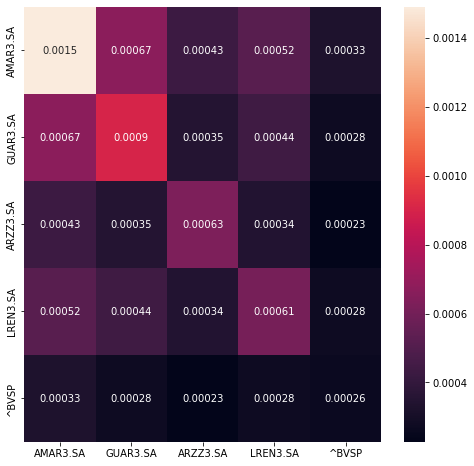

In [195]:
plt.figure(figsize=(8,8))
sns.heatmap(taxas_retorno.cov(), annot=True);

Entre as ações do portfólio, a maior covariância ocorre entre as ações da Marisa e da Guararapes (a controladora da Riachuelo), seguida da Renner com a Marisa. 

### Correlação entre as taxas de retorno

Além da covariância, outro indicador que é importante de analisar é a *correlação*. A correlação visa entender o comportamento entre dois ativos. Isso significa compreender se eles apresentam desempenho semelhante ou diferente, de acordo com os acontecimentos econômicos. No nosso exemplo, o seguinte cenário ocorre:

In [196]:
taxas_retorno.corr()

,AMAR3.SA,GUAR3.SA,ARZZ3.SA,LREN3.SA,^BVSP
AMAR3.SA,1.000000,0.576183,0.443337,0.541778,0.520810
GUAR3.SA,0.576183,1.000000,0.464902,0.589277,0.564134
ARZZ3.SA,0.443337,0.464902,1.000000,0.550062,0.557340
LREN3.SA,0.541778,0.589277,0.550062,1.000000,0.685230
^BVSP,0.520810,0.564134,0.557340,0.685230,1.000000


O mapa de calor pode nos dar uma representação gráfica melhor da situação:

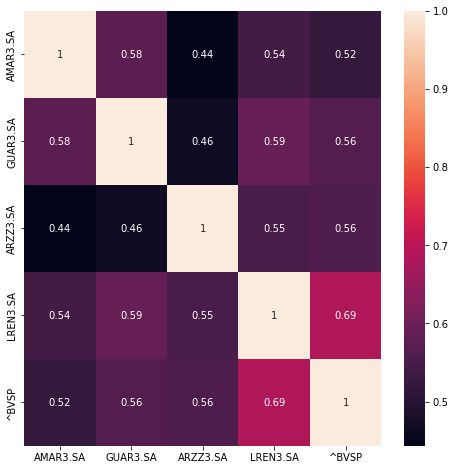

In [197]:
plt.figure(figsize=(8,8))
sns.heatmap(taxas_retorno.corr(), annot=True);

Percebemos que há um relativo equilíbrio na correlação das ações, sendo a Arezzo a menos afetada em caso de variação das outras. Ela também foi o ativo de maior correlação com o índice Bovespa, talvez pelo desempenho que teve a partir de março de 2020.

## Montando uma Carteira de Ativos

Podemos verificar como uma carteira que contenha um conjunto de ações se comporta no decorrer do tempo, através da média das taxas de retorno de cada uma delas. Isso indicará a performance geral da carteira, e pode ser feito usando uma propriedade do `DataFrame`: ao fazermos uma operação aritmética no objeto, ele realiza essa operação em cada um dos elementos da matriz. É possível, também, filtrar cada uma das colunas do `DataFrame`, isolando as informações de uma ação específica.

Sendo assim, ao fazermos a soma de cada uma das ações e dividirmos pelo total de ações, teremos uma nova coluna (`CARTEIRA`) com a média da taxa de retorno diária do conjunto de ações, como representado abaixo:



In [198]:
taxas_retorno_date["CARTEIRA"] = (taxas_retorno_date['AMAR3.SA'] + taxas_retorno_date['GUAR3.SA'] + 
                                   taxas_retorno_date['ARZZ3.SA'] + taxas_retorno_date['LREN3.SA']  )/4
taxas_retorno_date

,Date,AMAR3.SA,GUAR3.SA,ARZZ3.SA,LREN3.SA,^BVSP,CARTEIRA
0,2015-01-02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2015-01-05,-0.007610,-0.032159,-0.031836,-0.028193,-0.020724,-0.024949
2,2015-01-06,-0.063798,-0.003286,-0.019763,0.011453,0.010134,-0.018848
3,2015-01-07,0.018336,0.018190,0.010132,0.016872,0.030003,0.015882
4,2015-01-08,-0.010961,-0.014778,-0.004850,0.001185,0.009657,-0.007351
...,...,...,...,...,...,...,...
1910,2022-09-08,0.029230,0.024451,0.006416,-0.000384,0.001384,0.014928
1911,2022-09-09,0.052116,0.021979,0.009709,0.031400,0.021457,0.028801
1912,2022-09-12,0.045810,0.012212,0.016397,0.020642,0.009809,0.023765
1913,2022-09-13,-0.015038,-0.068593,-0.007314,-0.006956,-0.023310,-0.024475


Temos agora a possibilidade de comparar a performance da carteira com o Índice Bovespa, selecionando as colunas `Data`, `CARTEIRA` e `^BVSP` do nosso conjunto de dados:

In [199]:
taxas_retorno_port = taxas_retorno_date.filter(["Date", "CARTEIRA", '^BVSP'])
taxas_retorno_port

,Date,CARTEIRA,^BVSP
0,2015-01-02,0.000000,0.000000
1,2015-01-05,-0.024949,-0.020724
2,2015-01-06,-0.018848,0.010134
3,2015-01-07,0.015882,0.030003
4,2015-01-08,-0.007351,0.009657
...,...,...,...
1910,2022-09-08,0.014928,0.001384
1911,2022-09-09,0.028801,0.021457
1912,2022-09-12,0.023765,0.009809
1913,2022-09-13,-0.024475,-0.023310


E a representação gráfica fica conforme abaixo:

In [200]:
figuraComparacao = px.line(title = 'Comparação de retorno Carteira x Bovespa')
for i in taxas_retorno_port.columns[1:]:
  figuraComparacao.add_scatter(x = taxas_retorno_port["Date"] ,y = taxas_retorno_port[i], name = i)
figuraComparacao.add_hline(y = taxas_retorno_port['CARTEIRA'].mean(), line_color="green", line_dash="dot", )
figuraComparacao.show()

Percebemos que a carteira teve uma performance similar ao índice até o período de março de 2020, que foi quando a pandemia do Covid 19 começou a impactar os negócios no Brasil. A partir daí, temos uma performance da carteira um pouco melhor do que o índice, puxado, provavelmente, pelo desempenho da Arezzo. Podemos agora analisar o índice de correlação entre a carteira e o índice:

In [201]:
taxas_retorno_port_corr = taxas_retorno_date.filter(["CARTEIRA", "^BVSP"])
taxas_retorno_port_corr

,CARTEIRA,^BVSP
0,0.000000,0.000000
1,-0.024949,-0.020724
2,-0.018848,0.010134
3,0.015882,0.030003
4,-0.007351,0.009657
...,...,...
1910,0.014928,0.001384
1911,0.028801,0.021457
1912,0.023765,0.009809
1913,-0.024475,-0.023310


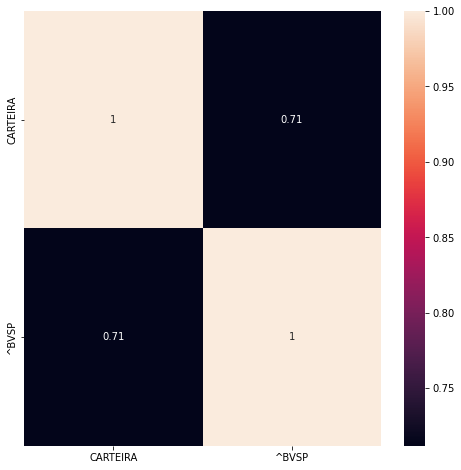

In [202]:
plt.figure(figsize=(8,8))
sns.heatmap(taxas_retorno_port_corr.corr(), annot=True);

## Alocação Aleatória de Ativos - Portfólio Markowitz

Harry Markowitz desenvolveu, nos anos 50, a Teoria Moderna do Portfólio. Essa teoria  apresenta um modelo de montagem de carteira que analisa os ativos com suposições de risco, retorno e correlação futuros. A partir dos dados é calculado uma série de possíveis alocações, entre essas possíveis alocações os portfólios que maximizam o retorno esperado e minimizam o risco formam a chamada fronteira eficiente. A TMP leva em consideração que o investidor sempre deseja ter o maior retorno possível dado determinado nível de tolerância ao risco.

O primeiro passo para simularmos um portfólio aleatório é retirarmos o índice BOVESPA do `DataFrame` que contém os dados, de forma que tenhamos apenas os dados das empresas:

In [203]:
acoes_port = acoes_df.copy()
acoes_port.drop(labels = ["^BVSP"], axis=1, inplace=True)
acoes_port

,Date,AMAR3.SA,GUAR3.SA,ARZZ3.SA,LREN3.SA
0,2015-01-02,13.190909,10.23000,25.850000,12.446208
1,2015-01-05,13.090909,9.90625,25.040001,12.100207
2,2015-01-06,12.281818,9.87375,24.549999,12.239591
3,2015-01-07,12.509090,10.05500,24.799999,12.447848
4,2015-01-08,12.372727,9.90750,24.680000,12.462606
...,...,...,...,...,...
1910,2022-09-08,2.430000,10.35000,92.250000,26.020000
1911,2022-09-09,2.560000,10.58000,93.150002,26.850000
1912,2022-09-12,2.680000,10.71000,94.690002,27.410000
1913,2022-09-13,2.640000,10.00000,94.000000,27.219999


Definiremos agora um método que gera, de forma aleatória, um peso para cada uma das ações especificadas. Esse método também recebe como parâmetro o dinheiro investido, de forma que possa calcular o total do rendimento ao final daquela data. 

Há também dois parâmetros opcionais: o `seed`, que pode ser definido para modificar o número aleatório gerado, e um `Array` de melhores pesos, que é quando os pesos das ações podem ser definidos previamente. O retorno do método é uma tupla que contém:
- O `Dataset` com as taxas de retorno já modificadas de acordo com o peso
- A coluna `Date` separada
- Um `DataFrame` das ações com seus respectivos pesos
- A soma total do valor investido no decorrer do tempo. Esse número é recuperado acessando a coluna `soma valor` da última linha do `DataFrame`

A taxa de retorno também é calculada usando como base o valor total do dia dividido pelo valor total do dia anterior. Assim como feito anteriormente, a função `log` é usada para suavizar a curva.

In [204]:
def alocacao_ativos(dataset, dinheiro_total, seed = 0, melhores_pesos = []):
  dataset = dataset.copy()

  if seed != 0:
    np.random.seed(seed)

  if len(melhores_pesos) > 0:
    pesos = melhores_pesos
  else:  
    pesos = np.random.random(len(dataset.columns) - 1)
    #print(pesos, pesos.sum())
    pesos = pesos / pesos.sum()
    #print(pesos, pesos.sum())

  colunas = dataset.columns[1:]
  #print(colunas)
  for i in colunas:
    dataset[i] = (dataset[i] / dataset[i][0])

  for i, acao in enumerate(dataset.columns[1:]):
    #print(i, acao)
    dataset[acao] = dataset[acao] * pesos[i] * dinheiro_total
  
  dataset['soma valor'] = dataset.sum(axis = 1)

  datas = dataset['Date']
  #print(datas)

  dataset.drop(labels = ['Date'], axis = 1, inplace = True)
  dataset['taxa retorno'] = 0.0

  for i in range(1, len(dataset)):
    dataset['taxa retorno'][i] = np.log(dataset['soma valor'][i] / dataset['soma valor'][i - 1]) * 100

  acoes_pesos = pd.DataFrame(data = {'Ações': colunas, 'Pesos': pesos})

  return dataset, datas, acoes_pesos, dataset.loc[len(dataset) - 1]['soma valor']

In [205]:
dataset, datas, acoes_pesos, soma_valor = alocacao_ativos(acoes_port, 10000, 3)

C:\Users\demet\AppData\Local\Temp\ipykernel_4780\2210113608.py:24: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



In [206]:
dataset

,AMAR3.SA,GUAR3.SA,ARZZ3.SA,LREN3.SA,soma valor,taxa retorno
0,2672.896416,3436.479638,1411.694254,2478.929692,10000.000000,0.000000
1,2652.633168,3327.725116,1367.459377,2410.016226,9757.833887,-2.451466
2,2488.685760,3316.807569,1340.699897,2437.777407,9583.970634,-1.797846
3,2534.738279,3377.693583,1354.352646,2479.256397,9746.040906,1.676916
4,2507.106807,3328.145108,1347.799385,2482.195792,9665.247091,-0.832446
...,...,...,...,...,...,...
1910,492.395049,3476.790534,5037.864332,5182.442052,14189.491966,0.908966
1911,518.737145,3554.052389,5087.014311,5347.754367,14507.558211,2.216808
1912,543.052974,3597.722258,5171.115294,5459.290290,14771.180817,1.800827
1913,534.947714,3359.217783,5133.433574,5421.447602,14449.046673,-2.204960


In [207]:
acoes_pesos

,Ações,Pesos
0,AMAR3.SA,0.267290
1,GUAR3.SA,0.343648
2,ARZZ3.SA,0.141169
3,LREN3.SA,0.247893


In [208]:
datas

0      2015-01-02
1      2015-01-05
2      2015-01-06
3      2015-01-07
4      2015-01-08
          ...    
1910   2022-09-08
1911   2022-09-09
1912   2022-09-12
1913   2022-09-13
1914   2022-09-14
Name: Date, Length: 1915, dtype: datetime64[ns]

In [209]:
float(soma_valor).__round__(2)

14460.55

Com esses dados, podemos plotar o gráfico do retorno diário do portfólio (em %) e da evolução do patrimônio (em R$):

In [210]:
figura = px.line(x = datas, y = dataset['taxa retorno'], title = 'Retorno diário do portfólio',
                labels=dict(x="Data", y="Retorno %"))
figura.add_hline(y = dataset['taxa retorno'].mean(), line_color="red", line_dash="dot", )
figura.show()

In [211]:
figura = px.line(title = 'Evolução do patrimônio')
for i in dataset.drop(columns = ['soma valor', 'taxa retorno']).columns:
  figura.add_scatter(x = datas, y = dataset[i], name = i)
figura.show()

Já a perfomance combinada da carteira pode ser verificada no gráfico abaixo, onde `soma valor` é mostrado ao longo do tempo. 

In [212]:
figura = px.line(x = datas, y = dataset['soma valor'], 
                 title = 'Evolução do patrimônio da Carteira',
                 labels=dict(x="Data", y="Valor R$"))
figura.add_hline(y = dataset['soma valor'].mean(), 
                 line_color="green", line_dash="dot", )
figura.show()

Mais estatísticas sobre o portfólio aleatório:

Retorno:

In [213]:
dataset.loc[len(dataset) - 1]['soma valor'] / dataset.loc[0]['soma valor'] - 1

0.446055092923465

Desvio-padrão:

In [214]:
dataset['taxa retorno'].std()

2.2561626493603635

## Portfólio ótimo utilizando o Índice de Sharpe

O Índice de Sharpe (Sharpe Ratio) foi um índice desenvolvido por William F. Sharpe, e é usado para ajudar investidores a entender o retorno de um investimento comparado com seu risco. Ele é definido como o ganho médio adquirido dividido pelo desvio-padrão daquela taxa, onde o desvio-padrão dá uma noção da volatilidade daquela ação. Para o nosso caso, utilizaremos a média para definir o ganho médio da carteira:

In [215]:
# Sharpe Ratio
(dataset['taxa retorno'].mean() / dataset['taxa retorno'].std())

0.008536855202272247

Lucro total da operação:

In [216]:
dinheiro_total = 10000
float(soma_valor - dinheiro_total).__round__(2)

4460.55

### Simulação da Fronteira Eficiente

Fronteira Eficiente é um conceito apresentado por Harry Markowitz. Nele é apresentado que o risco de uma carteira não é dado simplesmente pela média dos ativos individuais, mas sim pela diversificação da carteira de investimento como um todo.

No modelo de Markowitz, a maximização da satisfação do investidor é definida no que ele chama de “investidor racional”. Ou seja, obter maior rentabilidade e menos risco nos títulos de renda variável.

Dessa forma, a Fronteira Eficiente mostrará as composições de pesos dos ativos que trazem o melhor rendimento de acordo com a volatilidade aceita pelo investidor.

As informações necessárias para calcular a Fronteira Eficiente são: o retorno esperado dos ativos a serem considerados para compor a carteira, a volatilidade de cada um e a covariância entre eles.

Dessa forma, nosso primeiro passo é verificar o retorno esperado da carteira, conforme calculamos anteriormente:

In [217]:
acoes_port

,Date,AMAR3.SA,GUAR3.SA,ARZZ3.SA,LREN3.SA
0,2015-01-02,13.190909,10.23000,25.850000,12.446208
1,2015-01-05,13.090909,9.90625,25.040001,12.100207
2,2015-01-06,12.281818,9.87375,24.549999,12.239591
3,2015-01-07,12.509090,10.05500,24.799999,12.447848
4,2015-01-08,12.372727,9.90750,24.680000,12.462606
...,...,...,...,...,...
1910,2022-09-08,2.430000,10.35000,92.250000,26.020000
1911,2022-09-09,2.560000,10.58000,93.150002,26.850000
1912,2022-09-12,2.680000,10.71000,94.690002,27.410000
1913,2022-09-13,2.640000,10.00000,94.000000,27.219999


In [218]:
log_ret = acoes_port.copy()
log_ret.drop(labels = ["Date"], axis = 1, inplace = True)
log_ret = np.log(log_ret/log_ret.shift(1))
print("Taxa de retorno das ações:")
log_ret

Taxa de retorno das ações:


,AMAR3.SA,GUAR3.SA,ARZZ3.SA,LREN3.SA
0,NaN,NaN,NaN,NaN
1,-0.007610,-0.032159,-0.031836,-0.028193
2,-0.063798,-0.003286,-0.019763,0.011453
3,0.018336,0.018190,0.010132,0.016872
4,-0.010961,-0.014778,-0.004850,0.001185
...,...,...,...,...
1910,0.029230,0.024451,0.006416,-0.000384
1911,0.052116,0.021979,0.009709,0.031400
1912,0.045810,0.012212,0.016397,0.020642
1913,-0.015038,-0.068593,-0.007314,-0.006956


Com essas taxas de retorno em mãos, vamos fazer uma simulação de diferentes pesos para cada ação, permitindo fazer uma massa de dados que nos possibilitará calcular:
- O retorno com aquela composição de ações, calculado como a soma das médias de cada taxa de retorno multiplicados pelo peso;
- A volatilidade geral da composição: 
  A variância do portfólio é um pouco mais complicada de calcular, nela é preciso levar em consideração que o retorno dos ativos tem um certo grau de correlação, apenas multiplicar o peso dos ativo pelas suas volatilidades, assim como é feito com o retorno, traria um resultado maior que o real, pois não seria levado em conta o poder de diminuição do risco que a diversificação oferece. Para fazer o cálculo da variância primeiro é feito com a multiplicação do vetor de pesos pela matriz de covariância, obtendo assim um vetor, e então outra multiplicação do vetor de pesos transposto pelo vetor resultante. A fórmula resultante pode ser vista abaixo:

$$
\sigma _{p}^{2}=\begin{bmatrix}
W_1 & ... & W_i & ... & W_n
\end{bmatrix}
\begin{bmatrix}
\sigma_1^2  & ... & \sigma_{i,1} & ... & \sigma_{n,1}\\ 
\vdots  & \ddots & \ddots  & \ddots & \vdots \\ 
\sigma_{i,1}  & \ddots & \sigma_i^2 &  \ddots & \sigma_{n,j} \\ 
\vdots  & \ddots & \ddots  &  \ddots & \vdots \\ 
\sigma_{n,1} & ... & \sigma_{n,j} & ... & \sigma_n^2
\end{bmatrix}
\begin{bmatrix}
W_1
\\ \vdots 
\\ W_i
\\ \vdots 
\\ W_n
\end{bmatrix}
$$

Resultando em:

$$
\sigma _{p}=\sqrt{\begin{bmatrix}
W_1 & ... & W_i & ... & W_n
\end{bmatrix}
\begin{bmatrix}
\sigma_1^2  & ... & \sigma_{i,1} & ... & \sigma_{n,1}\\ 
\vdots  & \ddots & \ddots  & \ddots & \vdots \\ 
\sigma_{i,1}  & \ddots & \sigma_i^2 &  \ddots & \sigma_{n,j} \\ 
\vdots  & \ddots & \ddots  &  \ddots & \vdots \\ 
\sigma_{n,1} & ... & \sigma_{n,j} & ... & \sigma_n^2
\end{bmatrix}
\begin{bmatrix}
W_1
\\ \vdots 
\\ W_i
\\ \vdots 
\\ W_n
\end{bmatrix}}
$$
  
- O Índice de Sharpe de cada composição, que é o valor do retorno dividido pela volatilidade.

A simulação está criada abaixo, onde são montados 10000 potfólios com diferentes pesos em cada uma das ações, e os cálculos são realizados conforme a definição feita acima:

In [219]:
np.random.seed(11)
num_ports = 10000
all_weights = np.zeros((num_ports, len(acoes_port.columns[1:])))
ret_arr = np.zeros(num_ports)
vol_arr = np.zeros(num_ports)
sharpe_arr = np.zeros(num_ports)

for x in range(num_ports):
    # Weights
    weights = np.array(np.random.random(4))
    weights = weights/np.sum(weights)
    
    # Save weights
    all_weights[x,:] = weights
    
    # Expected return
    ret_arr[x] = np.sum((log_ret.mean() * weights))
    
    # Expected volatility
    vol_arr[x] = np.sqrt(np.dot(weights.T, np.dot(log_ret.cov(), weights)))
    
    # Sharpe Ratio
    sharpe_arr[x] = ret_arr[x]/vol_arr[x]

A biblioteca `NumPy` nos permite recuperar o valor máximo de um array através da função `max`. No caso, o valor que nos interessa é o que tem o maior Índice de Sharpe, pois nesse caso temos a melhor relação entre o rendimento e o risco da carteira. No caso que simulamos, o resultado está descrito abaixo:

In [220]:
print("Max Sharpe Ratio: {}". format(sharpe_arr.max()))
print("Local do Max Sharpe Ratio: {}". format(sharpe_arr.argmax()))

Max Sharpe Ratio: 0.024945569752822583
Local do Max Sharpe Ratio: 7381


Os pesos de cada uma das ações ficaria assim:


In [221]:
all_weights

array([[0.1298869 , 0.01403219, 0.3337556 , 0.52232531],
       [0.29891069, 0.34530725, 0.0090916 , 0.34669047],
       [0.35792416, 0.32333613, 0.27741566, 0.04132405],
       ...,
       [0.07171737, 0.33653583, 0.22621183, 0.36553497],
       [0.2036093 , 0.2491249 , 0.11637489, 0.4308909 ],
       [0.52262138, 0.18462982, 0.04183895, 0.25090985]])

In [230]:
# Pesos do Portfólio do Max Sharpe Ratio
pesosPortfolioMaxSharpe = all_weights[sharpe_arr.argmax(),:]
print('Porcentagem de alocação para cada uma das ações:')
for i in range(len(portfolio)):
    porcentagemAlocacao = (pesosPortfolioMaxSharpe[i] * 100)
    print(portfolio[i], ':', porcentagemAlocacao.round(2), '%')


Porcentagem de alocação para cada uma das ações:
AMAR3.SA : 0.46 %
GUAR3.SA : 6.67 %
ARZZ3.SA : 68.27 %
LREN3.SA : 24.6 %


In [231]:
# salvando os dados do Max Sharpe Ratio
max_sr_ret = ret_arr[sharpe_arr.argmax()]
max_sr_vol = vol_arr[sharpe_arr.argmax()]
print('Taxa ótima de retorno do Max Sharpe Ratio:',max_sr_ret)
print('Taxa ótima de volatilidade do Max Sharpe Ratio:',max_sr_vol)

Taxa ótima de retorno do Max Sharpe Ratio: 0.000558167350817094
Taxa ótima de volatilidade do Max Sharpe Ratio: 0.0223754099965561


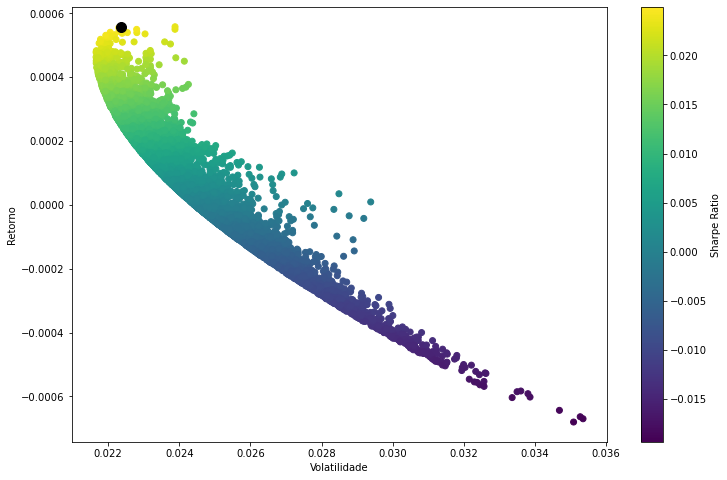

In [236]:
plt.figure(figsize=(12,8))
plt.scatter(vol_arr, ret_arr, c=sharpe_arr, cmap='viridis')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatilidade')
plt.ylabel('Retorno')
plt.scatter(max_sr_vol, max_sr_ret,c='black', s=100) # black dot
plt.show()

Nós podemos ver no gráfico acima o conjunto de portfólios simulados, pois o peso $w_i$ de cada ativo foi simulado e criamos um conjunto de $n = 10000$ carteiras e escolhemos no ponto preto a que tem maior **Sharpe Ratio**, pelas razões explicadas anteriormente. Esse dado nos dá uma noção do portfólio ponderado pelo risco.

Com essas simulações, podemos fazer uma representação gráfica da Fronteira Eficiente. Para isso, tentaremos recuperar os pesos que retornam o máximo Índice de Sharpe para cada volatilidade, de forma que seja possível achar os pontos de menor volatilidade que tenham a maior taxa de retorno.

Pelo conceito, deveríamos achar a maior taxa de retorno para essa relação, mas não há uma forma computacional nas nossas bibliotecas que faça isso. Entretanto, a biblioteca `SciPy` possui uma função de otimização que permite achar os argumentos mínimos de uma função para se chegar a um determinado limite (`optimize.minimize`). Por essa razão, faremos o raciocínio inverso: calcularemos o Sharpe Ratio negativo, e idenficaremos quais pesos fazem com que a função obtenha o resultado esperado.

Abaixo definimos algumas funções de apoio para a otimização:

In [238]:
def get_ret_vol_sr(weights):
    weights = np.array(weights)
    ret = np.sum(log_ret.mean() * weights)
    vol = np.sqrt(np.dot(weights.T, np.dot(log_ret.cov(), weights)))
    sr = ret/vol
    return np.array([ret, vol, sr])

def neg_sharpe(weights):
# the number 2 is the sharpe ratio index from the get_ret_vol_sr
    return get_ret_vol_sr(weights)[2] * -1

def check_sum(weights):
    #return 0 if sum of the weights is 1
    return np.sum(weights)-1

E aqui, definimos os parâmetros da otimização:
- A soma dos pesos simulados deve dar 1, indicando que os pesos, somados, dão 100%
- Os pesos devem variar de 0 a 1
- O peso inicial de todas as carteiras é 0.2

In [241]:
cons = ({'type': 'eq', 'fun': check_sum})
bounds = ((0,1), (0,1), (0,1), (0,1))
init_guess = ((0.2),(0.2),(0.2),(0.2))

Com essas restrições definidas, é possível chamar a rotina de otimização:

In [242]:
op_results = optimize.minimize(neg_sharpe, init_guess, method="SLSQP", bounds= bounds, constraints=cons)
print(op_results)

     fun: -0.027033948813040595
     jac: array([ 5.54486825e-02,  1.71560592e-02, -6.93323091e-06,  6.88640866e-05])
 message: 'Optimization terminated successfully'
    nfev: 60
     nit: 12
    njev: 12
  status: 0
 success: True
       x: array([2.28983499e-16, 0.00000000e+00, 9.08523441e-01, 9.14765588e-02])


Para montagem do gráfico, criamos um espaço de 200 retornos que varia de -0,02% a 0,06%. Esses limites foram definidos com base no gráfico montado anteriormente:

In [256]:
frontier_y = np.linspace(-0.0002, 0.0006, 200)

In [257]:
def minimize_volatility(weights):
    return get_ret_vol_sr(weights)[1]

Com esse espaço de taxa de retornos, utilizaremos a função `minimize` para verificar quais conjuntos de pesos resultam na menor volatilidade possível para cada retorno, maximizando o Sharpe Ratio: 

In [258]:
frontier_x = []

for possible_return in frontier_y:
    cons = ({'type':'eq', 'fun':check_sum},
            {'type':'eq', 'fun': lambda w: get_ret_vol_sr(w)[0] - possible_return})
    
    result = optimize.minimize(minimize_volatility,init_guess,method='SLSQP', bounds=bounds, constraints=cons)
    frontier_x.append(result['fun'])

Com os dados em mãos, podemos plotar no gráfico o conjunto de dados de retorno x volatilidade que foi montado com essa simulação, identificando, assim, a Fronteira Eficiente.

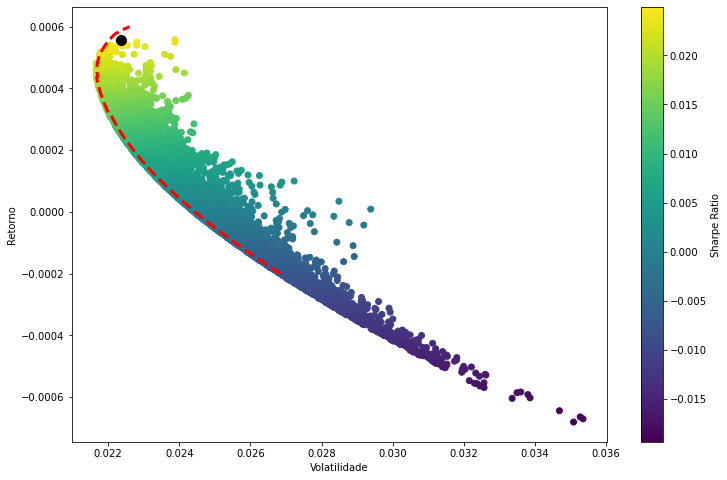

In [261]:
plt.figure(figsize=(12,8))
plt.scatter(vol_arr, ret_arr, c=sharpe_arr, cmap='viridis')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatilidade')
plt.ylabel('Retorno')
plt.plot(frontier_x,frontier_y, 'r--', linewidth=3)
plt.scatter(max_sr_vol, max_sr_ret,c='black', s=100)
# plt.savefig('cover.png')
plt.show()

Com os dados de retorno das ações em mãos, podemos checar como é a distribuição de cada um dos itens da carteira:

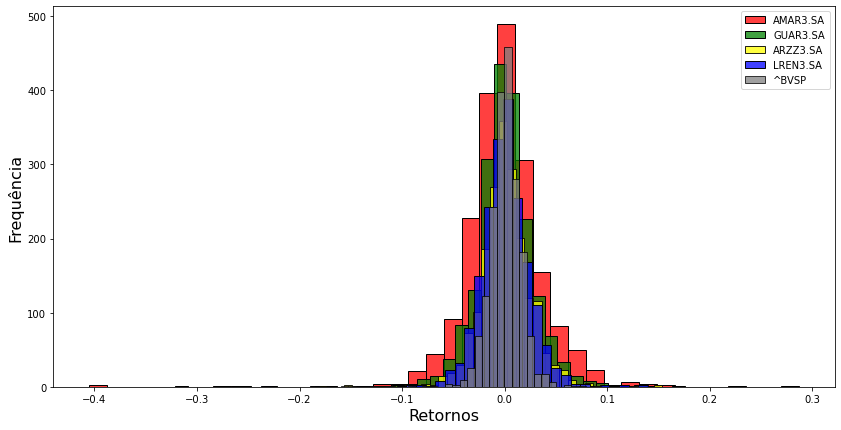

In [262]:
fig, ax = plt.subplots(figsize=(14,7))
ax = sns.histplot(taxas_retorno_date['AMAR3.SA'], bins=40, label='AMAR3.SA', color = 'red')
ax = sns.histplot(taxas_retorno_date['GUAR3.SA'], bins=40, label='GUAR3.SA', color='green')
ax = sns.histplot(taxas_retorno_date['ARZZ3.SA'], bins=40, label='ARZZ3.SA', color='yellow')
ax = sns.histplot(taxas_retorno_date['LREN3.SA'], bins=40, label='LREN3.SA', color='blue')
ax = sns.histplot(taxas_retorno_date['^BVSP'], bins=40, label='^BVSP', color='gray')
ax.set_xlabel("Retornos",fontsize=16)
ax.set_ylabel("Frequência",fontsize=16)
plt.legend()